**Author:** Beatrice Occhiena s314971. See [`LICENSE`](https://github.com/beatrice-occhiena/Computational_intelligence/blob/main/LICENSE) for details.
- institutional email: `S314971@studenti.polito.it`
- personal email: `beatrice.occhiena@live.it`
- github repository: [https://github.com/beatrice-occhiena/Computational_intelligence.git](https://github.com/beatrice-occhiena/Computational_intelligence.git)

**Resources:** These notes are the result of additional research and analysis of the lecture material presented by Professor Giovanni Squillero for the Computational Intelligence course during the academic year 2023-2024 @ Politecnico di Torino. They are intended to be my attempt to make a personal contribution and to rework the topics covered in the following resources.
- [https://github.com/squillero/computational-intelligence](https://github.com/squillero/computational-intelligence)
- Stuart Russel, Peter Norvig, *Artificial Intelligence: A Modern Approach* [3th edition]

# LAB 01 - Set Covering

## Introduction
---

### Problem Statement
The Set Covering Problem is a classical optimization problem in computer science and mathematics. It can be stated as follows:

> Given a set of elements $U = \{1, 2, ..., n\}$, and a collection $S_1, S_2, ..., S_m$ of subsets of $U$ such that $\bigcup_{i=1}^m S_i = U$, find the smallest sub-collection of $S_i$ whose union equals $U$. 

INPUT
- A finite universe $U$ of n elements
- A collection of subsets $S_i$ of $U$

OUTPUT: A sub-collection of $S_i$ whose union equals $U$

OBJECTIVE: Minimize the number of sets in the sub-collection

### Project Objectives

**1 - Implementation of Search Algorithms**

The aim of this project is to implement a set of search algorithms to efficiently solve the Set Covering Problem. We are going to explore the differences between the following algorithms in terms of performance and quality of the solution.
- Depth-First Search
- Breadth-First Search
- Best-First Search (Greedy)
- A* Search

**2 - Integration of Heuristic Function (H)**

Focusing on the A* search algorithm, we will employ a heuristic function (H) to guide the search process. The heuristic function estimates the distance from the current state to the goal state. 
To be sure to find the optimal solution, the heuristic function must be:
- Admissible: It never overestimates the cost of reaching the goal, so that $H(n) \leq H^*(n)$
- Consistent: It satisfies the triangle inequality, so that $H(n) \leq c(n, a, n') + H(n')$

In this project, we will explore different heuristics for the Set Covering Problem and compare their performances in terms of:
- Number of nodes expanded
- Number of nodes generated
- Quality of the solution


**3 - Special Sets Consideration**

In practice, some subsets might have unique characteristics or properties. We will investigate how to handle "special sets" within the context of the Set Covering Problem to improve the efficiency of the search.

**4 - Optimizing Set Order**

The order in which sets are selected can impact the efficiency of the solution. We will analyze strategies for optimizing the order in which subsets are considered to achieve more efficient and quicker solutions.


## Code Implementation
---

### Imported libraries

In [1]:
import numpy as np
import queue
from collections import namedtuple
import matplotlib.pyplot as plt


### Problem instance
First of all, we need to define the `UNIVERSE_SIZE` and the `NUMBER_OF_SETS`. Each set is represented by a vector of binary values, where 1 means that the element is present in the set, 0 means that the element is not present in the set. We can control the `DENSITY` of the sets by adjusting the probability of 1s in the vector.

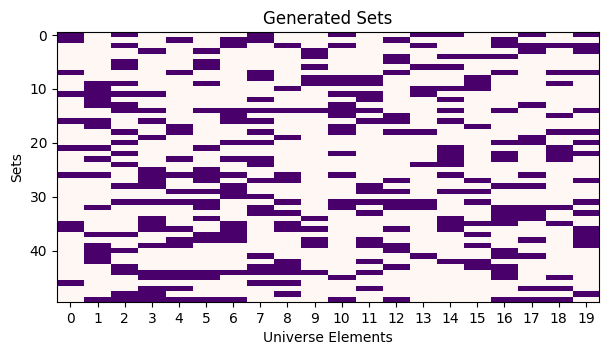

In [2]:
UNIVERSE_SIZE = 20
NUMBER_OF_SETS = 50
DENSITY = 0.3

"""
  SETS GENERATION
  Boolean array of shape (NUMBER_OF_SETS, UNIVERSE_SIZE) 
  where sets[i, j] is True if the j-th element of the universe is in the i-th set.
"""
sets = np.random.rand(NUMBER_OF_SETS, UNIVERSE_SIZE) < DENSITY

"""
  SETS VISUALIZATION
  Each set is represented by a row of the matrix.
  The elements of the universe are represented by the columns of the matrix.
"""
plt.figure(figsize=(7, 3.5))
plt.imshow(sets, cmap='RdPu', aspect='auto')
plt.title("Generated Sets")
plt.xlabel("Universe Elements")
plt.xticks(np.arange(UNIVERSE_SIZE))
plt.ylabel("Sets")
plt.show()

"""
  PROBLEM FEASIBILITY CHECK
  Check if the sets cover the universe
  i.e. if the sum of the sets is greater than 0 for all elements of the universe.
"""
assert np.all(np.sum(sets, axis=0) > 0)


### State Representation

To conveniently represent the state of the problem, we will use a `namedtuple` object of 2 elements:
- `taken`: a list of the sets that have been selected so far
- `not_taken`: a list of the sets that are still available

In Python, the namedtuple is a factory function for creating simple, immutable objects that are similar to tuples. It's a convenient way to define lightweight classes for storing and accessing data, typically used for creating simple data structures where we don't need to add methods or complex behaviors.

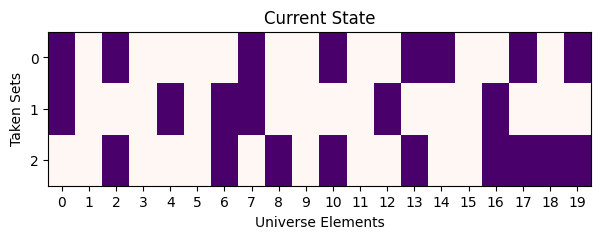

In [3]:
State = namedtuple("State",["taken","not_taken"])
initial_state = State(set(), set(range(NUMBER_OF_SETS)))

"""
  STATE VISUALIZATION
  Each state is represented by a pair of sets.
  The first set contains the indices of the sets that are taken.
  The second set contains the indices of the sets that are not taken.
"""
def visualize_state(state, is_goal=False):
  taken_sets = state.taken

  plt.figure(figsize=(7, 2))
  plt.imshow(sets[list(taken_sets), :], cmap='RdPu', aspect='auto')
  plt.title("Current State" if not is_goal else "Goal State")
  plt.xlabel("Universe Elements")
  plt.xticks(np.arange(UNIVERSE_SIZE))
  plt.ylabel("Taken Sets")
  # on the ticks of the y axis, show the indices of the taken sets
  plt.yticks(np.arange(len(taken_sets)), list(taken_sets))
  plt.show()

# example of state visualization
visualize_state(State(taken={0,1,2}, not_taken={3,4,5}))

### Problem Initialization
In [Search_Problems_Classes.py](../Lab_01/Search_Problems_Classes.py) I've defined three classes:
1. `Class Node`: that represents a node of the search tree or graph
2. `Class SearchProblem`: that represents the problem to be solved and a series of methods to manage its states, actions, heuristic function, etc.
3. `Class SearchStrategy`: that represents the search strategy to be used to solve the problem and a series of methods to manage the search process and the performance evaluation.

##### 🤚🏻 Action definition 
Since we are using a state representation that keeps track of the sets that have been selected and the sets that are still available, the action definition is straightforward: each time we select a set, we remove it from the `not_taken` list and add it to the `taken` list.
- step_cost = 1

##### 🎯 Goal test
The goal state is reached when the union of the sets in the `taken` list equals the universe. We can check this condition by converting the `taken` list into a binary vector and checking if the sum of the vector equals the `UNIVERSE_SIZE`.

##### 🧭 Heuristic function
The heuristic function estimates the distance from the current state to the goal state. In this case, we will use the number of elements that are still missing from the universe. We can compute this value by converting the `taken` list into a binary vector and checking how many 0s are in the vector.

In [4]:
from Search_Problems_Classes import SearchProblem

class SetCovering(SearchProblem):

  def is_goal(self, state):
    return np.sum(np.sum(sets[list(state.taken)], axis=0) > 0) == UNIVERSE_SIZE
  
  def actions(self, state):
    return list(state.not_taken)
  
  def apply_action(self, state, action):
    return State(state.taken | {action}, state.not_taken - {action})
  
  def h(self, node):
    return UNIVERSE_SIZE - np.sum(np.sum(sets[list(node.state.taken)], axis=0) > 0)

problem = SetCovering(initial_state)

In [5]:
from Search_Problems_Classes import SearchStrategy

type = 'tree_search'

# UNINFORMED SEARCH STRATEGIES
bfs = SearchStrategy(type,'breadth_first')
dfs = SearchStrategy(type,'depth_first')
ucs = SearchStrategy(type,'uniform_cost')
dls = SearchStrategy(type,'depth_limited', 2)
ids = SearchStrategy(type,'iterative_deepening')
bds = SearchStrategy(type,'bidirectional')

# INFORMED SEARCH STRATEGIES
greedy = SearchStrategy(type,'greedy_best_first')
astar = SearchStrategy(type,'a_star')

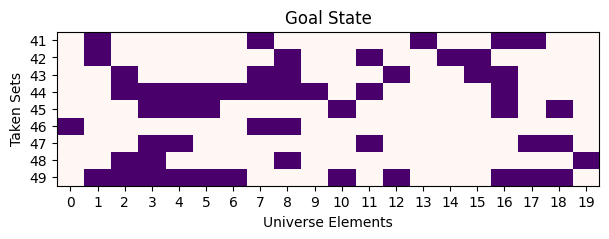

Search type: tree_search
Strategy: depth_first
----------------------
Solution found:
Path: [49, 48, 47, 46, 45, 44, 43, 42, 41]
Path cost: 9
Number of steps: 9
Max frontier size: 364


In [6]:
sol = dfs.search(problem)
visualize_state(sol.state, True) # visualize the solution
dfs.print_solution(problem, sol) # print information about the solution


In [7]:
sol = astar.search(problem)
visualize_state(sol.state, True) # visualize the solution
astar.print_solution(problem, sol) # print information about the solution

13
15
12
16
16
18
16
14
16
13
16
14
17
17
9
17
13


TypeError: '<' not supported between instances of 'Node' and 'Node'

#### Uninformed Search Algorithms


- Depth-First Search
- Breadth-First Search


#### Informed Search Algorithms

These algorithms use additional problem-specific information, often in the form of heuristics, to guide the search process toward the most promising solutions. They are implemented using a priority queue, where the priority of each node is determined by an evaluation function $f(n)$.

- Best-First Search: $f(n) = H(n)$
- A* Search: $f(n) = g(n) + H(n)$



In [ ]:
"""
frontier = queue.PriorityQueue()
frontier.put((evaluate(initial_state), initial_state))

counter = 0
_, current_state = frontier.get()
while not goal_check(current_state):
  counter += 1
  for action in current_state.not_taken:
    new_state = State(current_state.taken | {action}, current_state.not_taken - {action})
    frontier.put((evaluate(new_state), new_state))
  _, current_state = frontier.get()

visualize_state(current_state, True) # visualize the solution
print(f"Solved in {counter} steps with {len(current_state.taken)} sets")
"""

'\nfrontier = queue.PriorityQueue()\nfrontier.put((evaluate(initial_state), initial_state))\n\ncounter = 0\n_, current_state = frontier.get()\nwhile not goal_check(current_state):\n  counter += 1\n  for action in current_state.not_taken:\n    new_state = State(current_state.taken | {action}, current_state.not_taken - {action})\n    frontier.put((evaluate(new_state), new_state))\n  _, current_state = frontier.get()\n\nvisualize_state(current_state, True) # visualize the solution\nprint(f"Solved in {counter} steps with {len(current_state.taken)} sets")\n'

## Log of Experiments
